# Hands On Session: Uncovering brain-behavior relationships and overcoming overfitting with regularization

### by Adi Nair, Anderson Lab

In this tutorial, we'll examine how to perform dimensionality reduction such as PCA, NMF and PLS. And also perform decoding of behavior from neural activity using linear and logistic regression, going over important concepts such as regularization and overfitting. We'll also implement linear regression from scratch and learn about closed-form solutions. We'll be using data from VMHvl from a male mouse interacting with either females or males from [Remedios et ., 2017, Nature](https://https://www.nature.com/articles/nature23885)

### Table of contents
#### 0) Visualizing neural data and behavior
Simple exercises to plot neural and behavior data 

#### 1 a) PCA on neural data
Using sklearns' PCA to observe seperation of behavior in activity space

#### 1 b) Explained variance

#### 1 c) Cross validation for PCA
An essential step to determine the correct number of PCs in a dataset. Read more about it [here](https://drmdhumphries.medium.com/actually-you-very-much-can-apply-cross-validation-to-pca-7c00db0f9b62)

#### 2 a) Train test split 
A crucial process for any analysis

#### 2 b) Performing linear regression
Using sklearn's LinearRegression without any penalties

#### 2 c) Prediction and quatifying performance
Using confusion matrices to observe precision, recall & F1 scores

#### 3 a) Overcoming overfitting: LASSO or L2 Norm
Using LassoCV to perform L2 reg.

#### 3 b) Lasso model performance

#### 3 c) Overcoming overfitting: Ridge or L1 Norm
Using RidgeCV to perform L1 reg.

#### 3 d) Ridge model performance

#### 4) Class imbalance
A crucial step in classification and decoding problems

#### 5) Logistic regression
A better classification tool using sklearn's LogisticRegression

#### 6 a) Digging deeper and implementing regression from scratch
Linear regression has a closed form solution, meaning that it can be solved mathematically without optimization. Write out the math here!

#### 6 b) Testing our regression function

#### 7) Implementing regularization from scratch
Add regularization to the closed form solution

#### 8) Partial least squares regression
Find a latent dimension correlated with aggression here

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adityanairneuro/anderson_lab/blob/main/code/dimensionality_regression_regularization.ipynb)

In [33]:
# Import neccessary modules and helper functions
# Sort imports alphabetically

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from matplotlib import image
from sklearn.linear_model import LogisticRegression

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    

In [34]:
# Helper functions for nmf
import numpy.linalg as nla
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# from nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

def normal_eq_comb(AtA, AtB, PassSet=None):
    """ Solve many systems of linear equations using combinatorial grouping.
    M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
    Parameters
    ----------
    AtA : numpy.array, shape (n,n)
    AtB : numpy.array, shape (n,k)
    Returns
    -------
    (Z,num_cholesky,num_eq)
    Z : numpy.array, shape (n,k) - solution
    num_cholesky : int - the number of unique cholesky decompositions done
    num_eq: int - the number of systems of linear equations solved
    """
    num_cholesky = 0
    num_eq = 0
    if AtB.size == 0:
        Z = np.zeros([])
    elif (PassSet is None) or np.all(PassSet):
        Z = nla.solve(AtA, AtB)
        num_cholesky = 1
        num_eq = AtB.shape[1]
    else:
        Z = np.zeros(AtB.shape)
        if PassSet.shape[1] == 1:
            if np.any(PassSet):
                cols = PassSet.nonzero()[0]
                Z[cols] = nla.solve(AtA[np.ix_(cols, cols)], AtB[cols])
                num_cholesky = 1
                num_eq = 1
        else:
            #
            # Both _column_group_loop() and _column_group_recursive() work well.
            # Based on preliminary testing,
            # _column_group_loop() is slightly faster for tiny k(<10), but
            # _column_group_recursive() is faster for large k's.
            #
            grps = _column_group_recursive(PassSet)
            for gr in grps:
                cols = PassSet[:, gr[0]].nonzero()[0]
                if cols.size > 0:
                    ix1 = np.ix_(cols, gr)
                    ix2 = np.ix_(cols, cols)
                    #
                    # scipy.linalg.cho_solve can be used instead of numpy.linalg.solve.
                    # For small n(<200), numpy.linalg.solve appears faster, whereas
                    # for large n(>500), scipy.linalg.cho_solve appears faster.
                    # Usage example of scipy.linalg.cho_solve:
                    # Z[ix1] = sla.cho_solve(sla.cho_factor(AtA[ix2]),AtB[ix1])
                    #
                    Z[ix1] = nla.solve(AtA[ix2], AtB[ix1])
                    num_cholesky += 1
                    num_eq += len(gr)
                    num_eq += len(gr)
    return Z, num_cholesky, num_eq


def nnlstsq(A, B, is_input_prod=False, init=None):
    """ Nonnegativity-constrained least squares with block principal pivoting method and column grouping
    Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
    J. Kim and H. Park, Fast nonnegative matrix factorization: An active-set-like method and comparisons,
    SIAM Journal on Scientific Computing, 
    vol. 33, no. 6, pp. 3261-3281, 2011.
    Parameters
    ----------
    A : numpy.array, shape (m,n)
    B : numpy.array or scipy.sparse matrix, shape (m,k)
    Optional Parameters
    -------------------
    is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
            AtA and AtB, respectively. Default is False.
    init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
            Default is None.
    Returns
    -------
    X, (success, Y, num_cholesky, num_eq, num_backup)
    X : numpy.array, shape (n,k) - solution
    success : True/False - True if the solution is found. False if the algorithm did not terminate
            due to numerical errors.
    Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
    num_cholesky : int - the number of Cholesky factorizations needed
    num_eq : int - the number of linear systems of equations needed to be solved
    num_backup: int - the number of appearances of the back-up rule. See SISC paper for details.
    """
    if is_input_prod:
        AtA = A
        AtB = B
    else:
        AtA = A.T.dot(A)
        if sps.issparse(B):
            AtB = B.T.dot(A)
            AtB = AtB.T
        else:
            AtB = A.T.dot(B)

    (n, k) = AtB.shape
    MAX_ITER = n * 5

    if init is not None:
        PassSet = init > 0
        X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB, PassSet)
        Y = AtA.dot(X) - AtB
    else:
        X = np.zeros([n, k])
        Y = -AtB
        PassSet = np.zeros([n, k], dtype=bool)
        num_cholesky = 0
        num_eq = 0

    p_bar = 3
    p_vec = np.zeros([k])
    p_vec[:] = p_bar
    ninf_vec = np.zeros([k])
    ninf_vec[:] = n + 1
    not_opt_set = np.logical_and(Y < 0, ~PassSet)
    infea_set = np.logical_and(X < 0, PassSet)

    not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
    not_opt_colset = not_good > 0
    not_opt_cols = not_opt_colset.nonzero()[0]

    big_iter = 0
    num_backup = 0
    success = True
    while not_opt_cols.size > 0:
        big_iter += 1
        if MAX_ITER > 0 and big_iter > MAX_ITER:
            success = False
            break

        cols_set1 = np.logical_and(not_opt_colset, not_good < ninf_vec)
        temp1 = np.logical_and(not_opt_colset, not_good >= ninf_vec)
        temp2 = p_vec >= 1
        cols_set2 = np.logical_and(temp1, temp2)
        cols_set3 = np.logical_and(temp1, ~temp2)

        cols1 = cols_set1.nonzero()[0]
        cols2 = cols_set2.nonzero()[0]
        cols3 = cols_set3.nonzero()[0]

        if cols1.size > 0:
            p_vec[cols1] = p_bar
            ninf_vec[cols1] = not_good[cols1]
            true_set = np.logical_and(not_opt_set, np.tile(cols_set1, (n, 1)))
            false_set = np.logical_and(infea_set, np.tile(cols_set1, (n, 1)))
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols2.size > 0:
            p_vec[cols2] = p_vec[cols2] - 1
            temp_tile = np.tile(cols_set2, (n, 1))
            true_set = np.logical_and(not_opt_set, temp_tile)
            false_set = np.logical_and(infea_set, temp_tile)
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols3.size > 0:
            for col in cols3:
                candi_set = np.logical_or(
                    not_opt_set[:, col], infea_set[:, col])
                to_change = np.max(candi_set.nonzero()[0])
                PassSet[to_change, col] = ~PassSet[to_change, col]
                num_backup += 1

        (X[:, not_opt_cols], temp_cholesky, temp_eq) = normal_eq_comb(
            AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols])
        num_cholesky += temp_cholesky
        num_eq += temp_eq
        X[abs(X) < 1e-12] = 0
        Y[:, not_opt_cols] = AtA.dot(X[:, not_opt_cols]) - AtB[:, not_opt_cols]
        Y[abs(Y) < 1e-12] = 0

        not_opt_mask = np.tile(not_opt_colset, (n, 1))
        not_opt_set = np.logical_and(
            np.logical_and(not_opt_mask, Y < 0), ~PassSet)
        infea_set = np.logical_and(
            np.logical_and(not_opt_mask, X < 0), PassSet)
        not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
        not_opt_colset = not_good > 0
        not_opt_cols = not_opt_colset.nonzero()[0]

    return X, (success, Y, num_cholesky, num_eq, num_backup)

def censored_lstsq(A, B, M):
    """Solves least squares problem with missing data in B
    Note: uses a broadcasted solve for speed.
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """

    if A.ndim == 1:
        A = A[:,None]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    try:
        # transpose to get r x n
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
    except:
        r = T.shape[1]
        T[:,np.arange(r),np.arange(r)] += 1e-6
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:,None]
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    return X.T

def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False):
    """Fit PCA or NMF while holding out a fraction of the dataset.
    """

    # choose solver for alternating minimization
    if nonneg:
        solver = censored_nnlstsq
    else:
        solver = censored_lstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    if nonneg:
        U = np.random.rand(data.shape[0], rank)
    else:
        U = np.random.randn(data.shape[0], rank)

    # fit pca/nmf
    for itr in range(50):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err


def cv_kmeans(data, rank, p_holdout=.3, M=None):
    """Fit kmeans while holding out a fraction of the dataset.
    """

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize cluster centers
    Vt = np.random.randn(rank, data.shape[1])
    U = np.empty((data.shape[0], rank))
    rn = np.arange(U.shape[0])

    # initialize missing data randomly
    imp = data.copy()
    imp[~M] = np.random.randn(*data.shape)[~M]

    # initialize cluster centers far apart
    Vt = [imp[np.random.randint(data.shape[0])]]
    while len(Vt) < rank:
        i = np.argmax(np.min(cdist(imp, Vt), axis=1))
        Vt.append(imp[i])
    Vt = np.array(Vt)

    # fit kmeans
    for itr in range(50):
        # update cluster assignments
        clus = np.argmin(cdist(imp, Vt), axis=1)
        U.fill(0.0)
        U[rn, clus] = 1.0
        # update centroids
        Vt = censored_lstsq(U, imp, M)
        assert np.all(np.sum(np.abs(Vt), axis=1) > 0)
        # update estimates of missing data
        imp[~M] = np.dot(U, Vt)[~M]

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return clus, U, Vt, train_err, test_err


### But first!

A bit more about our dataset: the data you examined in part 1 comes from a head-mounting microendoscope which collected calcium imaging (GCaMP6s) data from a male mouse enaging in either mating behavior towards a female or aggressive behavior towards a male. After collection of the imaging data, a data extraction pipeline is used to identify cells and extract time evolving traces from the imaging video. Finally, experimenters perform computer-vision assisted annotation of behaviors to give you the behavior label binary vectors you are using today

<img src="vmhvl_recording.png" alt="Drawing" style="width: 500px;"/>

<!-- ![vmhvl_recording.png](attachment:vmhvl_recording.png) -->

### Load data

Just as before let's load this dataset

In [7]:

# data_path = '/home/sabra/Documents/Chen_Institute_DataSAI_for_Neuroscience/07_05_22_day1_overview/data/hypothalamus_calcium_imaging_remedios_et_al.mat'
# hypothalamus_data = loadmat(data_path);

remedios_data = loadmat("vmhvl_remedios.mat");
neural_data = remedios_data['neural_data']
attack_vector = remedios_data['attack_vector']
sex_vector = remedios_data['sex_vector']


### 0) Visualize neural and behavior data 
Now that we've examined neural activity of VMHvl in session 1, let's plot both a behavior raster showing attack behavior (present in attack_vector), intruder sex (present in sex_vector) and neural activity together. 

Attack is a behavior causally linked to VMHvl activity: activation this hypothalamus brain region using optogenetic can produce aggression (see: [Lin et ., 2011, Nature](https://www.nature.com/articles/nature09736) for some cool videos)

<br>

#### Generate a plot showing the behavior annotation array attack_vector, sex_vector along with neural activity below:
##### hint: use imshow

In [3]:
# Enter code here:

Text(0, 0.5, 'neurons')

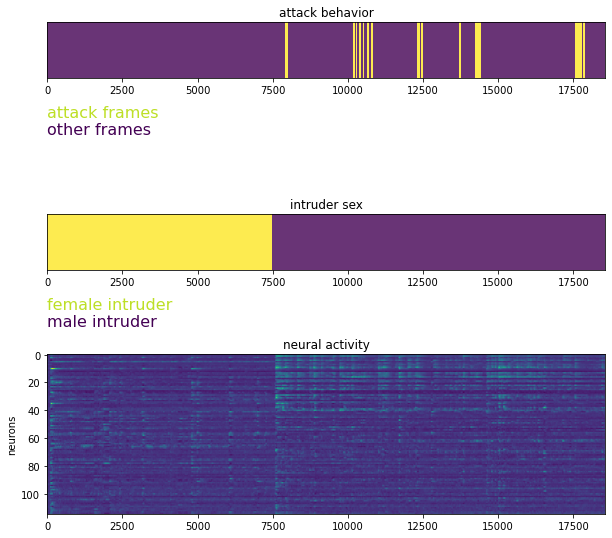

In [35]:
# Solution

# Plot behavior raster
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.0),fontsize=16)

ax2 = plt.subplot(312)

ax2.imshow(sex_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('intruder sex')
ax2.text(0,1.2,'female intruder',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'male intruder',color = cmap(0.0),fontsize=16)

ax3 = plt.subplot(313)
ax3.imshow(neural_data, aspect='auto')
ax3.set_title('neural activity')
ax3.set_ylabel('neurons')

### 1) Dimensionality reduction!
### 1 a) Principal components analysis (pca)
Let's first perform PCA and examine how sex is represented in two PCs. PCA can be easily performed in a few lines of code using sklearn's [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function. This function has already be imported for you! Click the link to examine some example calls of the function and then perform PCA below:

<br>

#### Generate a PCA plot colored by the behavior annotation array attack_vector below:

In [5]:
# Enter code here:

Text(0.02, 0.017, 'attack')

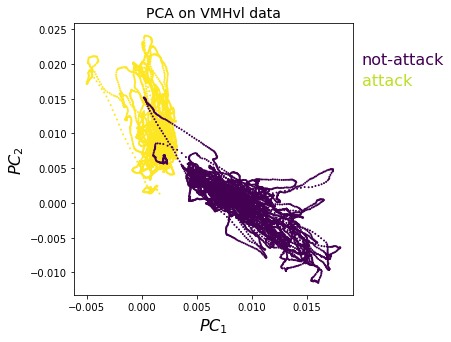

In [36]:
# Solution

# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (neural_data)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('viridis')

# neural_pcs.shape
ax.scatter(neural_pcs[0,],neural_pcs[1,], c = sex_vector, s = 1)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'not-attack',color = cmap(0.0),fontsize=16)
ax.text(0.02,0.017,'attack',color = cmap(0.9),fontsize=16)


#### Success! You've recreated a key observation in [Remedios et al](https://https://www.nature.com/articles/nature23885)
Intruder sex is easily seperable within a 2D PCA space! What about other behavior? Let's plot the same PCA but now color by the attack_vector instead:

Text(0.02, 0.017, 'attack')

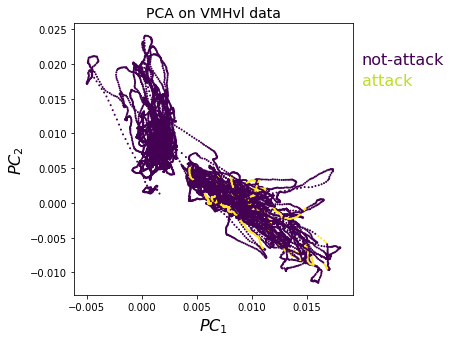

In [37]:
# Solution

# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (neural_data)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('viridis')

# neural_pcs.shape
ax.scatter(neural_pcs[0,],neural_pcs[1,], c = attack_vector, s = 1)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'not-attack',color = cmap(0.0),fontsize=16)
ax.text(0.02,0.017,'attack',color = cmap(0.9),fontsize=16)


### 1 b) Explained variance

Inspect the attributes in sklearn's sklearn's [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function and find a way to make a plot of variance explained by each PC in VMHvl


In [ ]:
# Enter code here

The top three PCs each explain this amount of variance: [0.45776448 0.13136509]
All together they explain:  0.5891295715983695 amount of the variance in the original data.


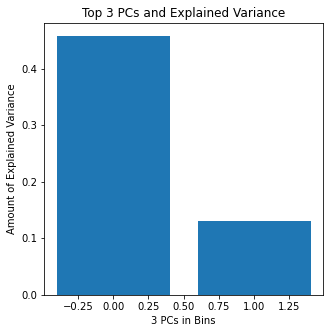

In [38]:
# Solution:
print('The top three PCs each explain this amount of variance:', pca_neural.explained_variance_ratio_)
print('All together they explain: ', np.sum(pca_neural.explained_variance_ratio_), 'amount \
of the variance in the original data.')
fig = plt.figure(figsize=[5,5])
_ = plt.title('Top 3 PCs and Explained Variance')
_ = plt.ylabel('Amount of Explained Variance')
_ = plt.xlabel('3 PCs in Bins')
_ = plt.bar([0,1], pca_neural.explained_variance_ratio_)

# This tells me that the first PC does a decent job of caputuring variance in the data.

#### As you can see, VMHvl is fairly low dimensional, two PCs can account for almost 60% of variance in the data!

### 1 c) Cross-validation for PCA

Let's kick things up a notch! In cell 2 of this notebook, you can find functions that implement cross validation for PCA as well as NMF. Use these functions to cross validate PCA & NMF and plot a train test curve below:

In [ ]:
# Enter code here

In [ ]:
# Solution
train_err, test_err = [], []

ranks = np.arange(1, 16)
replicates = 1
# fit models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te = cv_pca(neural_data.T, rnk,)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of PCs')
ax.set_title('PCA')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()

#### Our validation procedue indicates at least 4 dimensions in the VMHvl compared to the noise limit, which is still very low dimensional!



### Correlating behavior and neural activity using linear regression
### 2 a) Train Test Split 
Attack behavior is fairly rare in our dataset, let's train a simple linear regression model to estimate if attack can be decoded from this population before we move to methods like partial least squares.

In regression, we predict the behavior as a linear combination of the activity of neurons, as follows: $y = \alpha + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$.

where $y$ is the behavior we predict and $x_1, x_2, ... , x_n$ are the activities of individual neurons at a given time point.

The first step involves splitting data into train & test splits. As a first pass, let's split the last third of the data into the test set

<br>

#### Generate a train-test split in your dataset below (hint: use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn)

#### For this exercise, set the shuffle parameter to True

In [7]:
# Enter code here:

In [40]:
# Solution

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)

### 2 b) Performing regression

We will use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) module to perform the actual regression. 

This can be implemented in just a single line of code thanks to sklearn! 

#### Generate a regression model using sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function

In [9]:
# Enter code here:

In [41]:
# Solution

# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

### 2 c) Prediction and quatifying performance

To quantify performance, we show a confusion matrix with quantifies the degree of false positives and false negative for each class (attack and not-attack). These metrics can then be used to calculate an accuracy and precision value for each class. We use sklearn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) module to perform this. 
<br>

<img src="confusion_mat.png" alt="Drawing" style="width: 500px;"/>

Keep in mind, the output of regression will be a number, not a class label. This output represents a probability (but can be negative since linear regression does not impose non-negativity). We need to threshold the output by a value (say 0.4 as an example) to generate a binary signal that be compared with attack_vector.
<br>
#### Use sklearn's [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) and [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to quantify performance of your linear model

In [11]:
# Enter code here

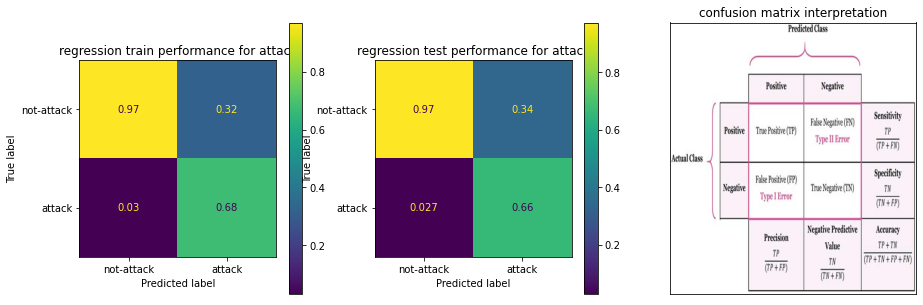

In [174]:
# Solution

imgconfusion = image.imread("confusion_mat.png")

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(132)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

ax3 = plt.subplot(133)
ax3.imshow(imgconfusion, aspect='auto')
ax3.set_title('confusion matrix interpretation')
ax3.set_yticks([])
ax3.set_xticks([])
ax3.grid(None)

This approach reveals perhaps the most common problem faced in ML, namely overfitting. Here, the train performance of the linear model suggests that model has learnt to distinguish attack frames, however when applied on a held out test dataset, the model performance collapses.

Let's also observe this as a behavior raster:

<br>

#### Create a plot showing both the predicted behavior raster and actual behavior raster for attack

In [13]:
# Enter code here:

Text(0, 1.5, 'other frames')

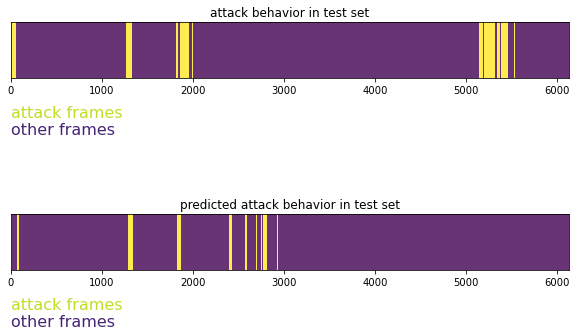

In [43]:
# Solution

# plot neural activity, showing frames of attack
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(test_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 a) Overcoming Overfitting: LASSO or L2 Norm

To overcome overfitting, we apply regularization, a method where a penalty is introduced to curb overfitting. Different types of regularization exist, here we will apply LASSO (least absolute shrinkage and selection operator), a method that allows us to enforce sparsity in predicted weighted from linear regression. LASSO is also known as L2 norm regularization.

Most methods in machine learning always involving comparing a data point with it's predicted value. This can be written as: $y - \beta x $ in the case of linear regression. The goal of machine learning is to estimate a value of $\beta$ that minimizes this error that we also call a loss function. In regularization, we apply a penalty to this error, which for LASSO is as follows:

$(y - \beta x) + \alpha \sum_{i = 1}^{p} |\beta_i|$

The value of lamba specifies the amount of regularization and is selected by cross-validation, a process where the training data is split into several 'folds' or portions and the model is trained on some folds and tested on the held-out fold. This is a process called model selection and is vital to most ML methods.

Lasso can be implemented using sklearn's [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). 

#### Read the help sklearn [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) help page and generate a lasso model with cross validation below

In [17]:
# Enter code here

Text(0.5, 1.0, 'model selection for lasso')

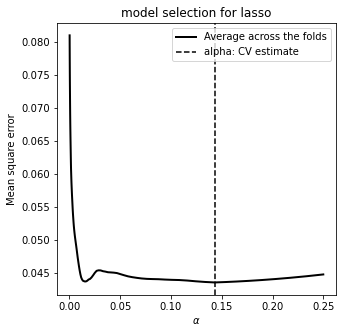

In [46]:
# Solution Lasso

from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)
# perform lasso
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

plt.figure(figsize=(5, 5))
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

# plot a line for the optimal value of alpha
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for lasso")

### 3 b) Lasso model performance

#### Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

In [19]:
# Enter code here:

Text(0.5, 1.0, 'regression test performance for attack')

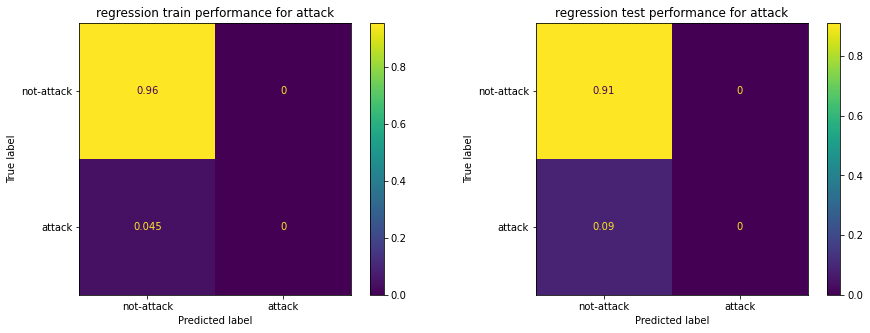

In [47]:
# Solution

# Training performance:
train_y_pred = lasso.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = lasso.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


#### Let's also visualize the predicted and actual ocurrences of attack behavior in the test set below

#### Generate a behavior plot for both predicted and actual occurence of attack below

Text(0, 1.5, 'other frames')

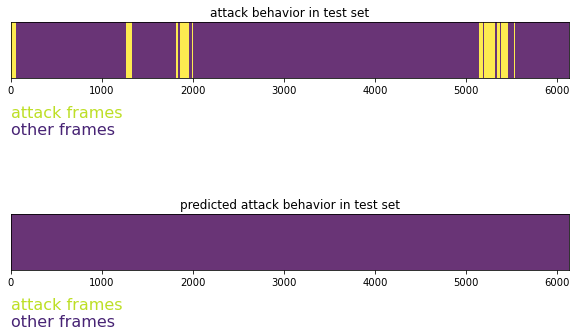

In [48]:
# Solution

# plot neural activity, showing frames of attack
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(test_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 c) Overcoming overfitting: Ridge or L1 Norm

#### Oh no! LASSO isn't sufficient 😞 

No worries, let's try another type of reglurization! Like LASSO (or L2 norm), a second type of regularization called Ridge (or L1 norm) might be useful here!:

In LASSO, we added a penalty to our regression problem as follows:

LASSO or L2 norm: $(y - \beta x) + \alpha \sum_{i = 1}^{p} |\beta_i|$

In Ridge, we add a slightly different penalty: 

Ridge or L1 norm: $(y - \beta x) + \alpha \sum_{i = 1}^{p} \beta_i^2 $

Explain more about Ridge regression here (maybe link to websites explaining a geometric interpretation 

#### Let's implement Ridge Regression using sklearn's RidgeCV method, once again the $\alpha$ parameter is determined by cross validation


#### Note: unlike LassoCV, we need to provide a list of alpha values for Ridge CV. As a first example, try values from 0-200 in intervals of 1.

In [21]:
# Enter code here:

Text(0.5, 1.0, 'model selection for ridge')

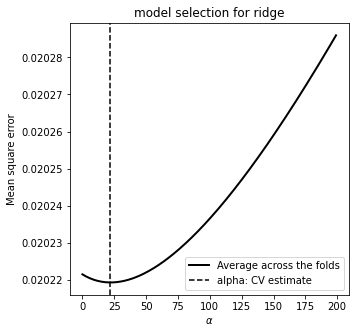

In [49]:
# Solution:

# Solution Ridge
# changing to Ridge to make it consistent with detailed implementation below:

# from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = False,
                                                    random_state=42)

# Ridge requires us to provide a list of alpha values
alphas=np.arange(1e-3,200,1)
ridge = RidgeCV(alphas, store_cv_values=True).fit(X_train, y_train)

plt.figure(figsize=(5, 5))
plt.plot(
    ridge.alphas,
    ridge.cv_values_.mean(axis=0),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(ridge.alpha_ , linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for ridge")

### 3 d) Ridge model performance

#### Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

In [ ]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

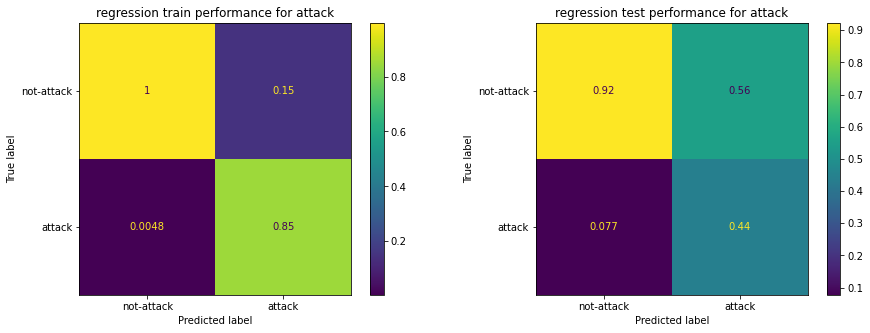

In [50]:
# Solution

# Training performance:
train_y_pred = ridge.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = ridge.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


### 4) Class Imbalance

#### okay... so we're doing a little better than before, but still not perfect!

### Notice something about our data, our train & test splits contain very few examples of the label 'attack'! This problem called [class imbalance]() is very detrimental to our problem! 

There are two ways to fix this: We can either shuffle our data to ensure that the 'attack' label is uniformly sprinkled throughout the data or we can sub-sample or stratify our data to include equal numbers of attack and not-attack labels. Try either one out!
Hint: It's as simple as including an argument in the function train_test_split

#### Redo regression (either Ridge or LASSO), but now including shuffled or sub-sampled classes below

In [ ]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

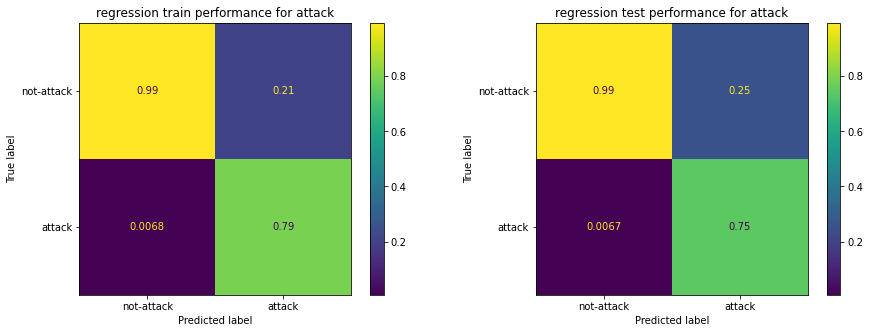

In [51]:
from sklearn.model_selection import cross_val_score

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

# Ridge requires us to provide a list of alpha values
alphas=np.arange(1e-3,200,1)
ridge = RidgeCV(alphas, store_cv_values=True).fit(X_train, y_train)


# Training performance:
train_y_pred = ridge.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = ridge.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


### YAY!! Our decoder works!! 

Let's finally make a plot showing our entire dataset: the attack annotation, neural data and predicted attack labels on all data

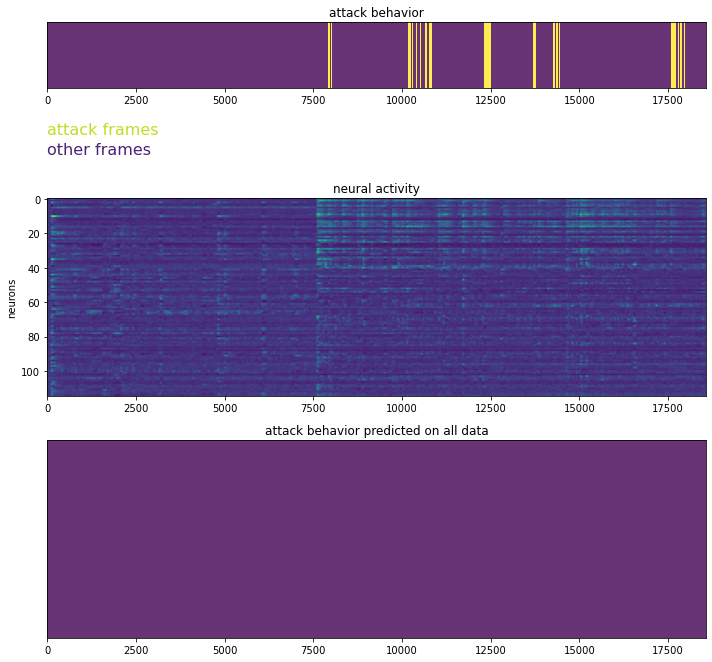

In [52]:
# Solution: 

# plot neural activity, showing frames of attack
all_y_pred = lasso.predict(neural_data.T)
all_y_pred_bin = np.zeros((1,np.size(neural_data[0,:])))
all_y_pred_bin[0,np.where(all_y_pred>0.4)] = 1

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.imshow(all_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax3.set_yticks([])
ax3.set_title('attack behavior predicted on all data')

plt.tight_layout() 

### 5) Logistic Regression

Linear regression is a great simple tool to quantifying correlations between neural activity and behavior. However, the output of regression wasn't a class label. Other methods such as logistic regression (and many others such as SVMs & Random Forests that we will cover in later tutorials) are better suited to classification problems.

Logistic regression adds a non-linear step between your prediction and coefficients. We start with a linear function: $f(x) = \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n $ which is then passed into a sigmoid function $p(x) = 1/(1+exp(-f(x))$. Thus the output of logistic regression is a probability between 0-1 of the prediction. This can be thresholded to produce a class label.

sklearn makes it very easy to perform Logistic regression using [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) that performs a built-in regularization step. Methods like logistic regression are more powerful than Linear regressison and can find an accurate solution sometimes even in the presence of a class imbalance

#### Let's implement Logistic Regression using sklearn below

In [ ]:
# Enter code here:


C:\Users\Adi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(0.5, 1.0, 'regression test performance for attack')

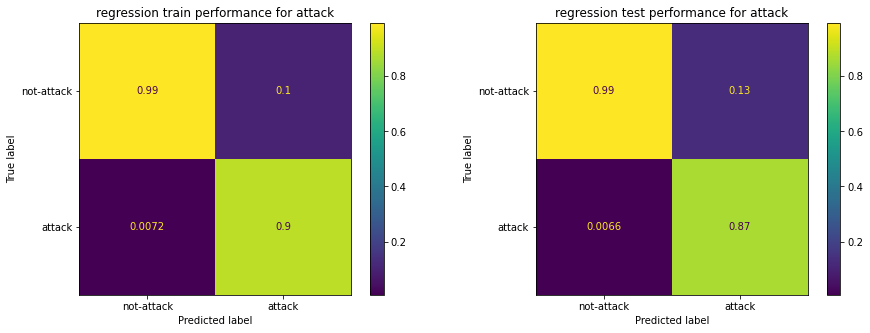

In [55]:
# Solution:

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.2, 
                                                    shuffle = True,
                                                    random_state=42)

# Ridge requires us to provide a list of alpha values
alphas=np.arange(1e-3,200,1)
# logistic = LogisticRegressionCV(cv=5, penalty='l1',random_state=0, solver='saga').fit(X_train, y_train)
logistic = LogisticRegression(penalty='l1',random_state=0, solver='saga').fit(X_train, y_train)

# Training performance:
train_y_pred = logistic.predict(X_train)

cm_train = confusion_matrix(y_train, train_y_pred, normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = logistic.predict(X_test)

cm_test = confusion_matrix(y_test, test_y_pred, normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### 6 a) Digging deeper and implementing regression from scratch:

We've implemented linear regression with sklearn's helpful functions, but how does regression actually work?

Let's gain an understanding by coding out the steps behind regression.
As we saw earlier, the goal of regression is to predict a variable y (behavior) as a linear combination of x (neural activity). This can be written as:

$y = \beta X$

Notice here that we switch to matrix notation, here $\beta$ is no longer a single number but a vector as long as the number of neurons (n). Hence it's dimensionas as $(1 x n)$. X here is also a matrix with dimensions $(n x t)$, where t is the number of time points.

There are many algorithms that allow us to find the $\beta's$ that make our weights. Some methods are iterative, using a loss function as defined earlier and reducing error over time. Luckily, linear regression also has an analytical solution which can be implemented in a single step!

The solution here is simply: 

$\beta = (X^{T} X)^{-1} X^{T} y$

Why is that?? We'll explain later but if you're curious you can read about the mathematical steps [here](https://dustinstansbury.github.io/theclevermachine/derivation-normal-equations):

Let's try this out!

We're going to use [Object Oriented Programming](https://en.wikipedia.org/wiki/Object-oriented_programming) here and create a class which can implement this solution for us 

#### Fill in the function below to implement linear regression 

In [136]:
# Enter code here

class LinearRegClosedSolution(object):
    
    def __int__(self):
        self.betas = []
        
    def fit(self, X, y):
        
        X = self._concatenate_ones(X)
        self.betas = # Enter equation for beta here
        
    def predict(self, X):
        b = self.betas
        prediction = # Enter equation for finding solution here
        return prediction
    

In [128]:
# Solution

class LinearRegClosedSolution(object):
    def __int__(self):
        self.betas = []
          
    def fit(self, X, y):
        if len(X.shape) == 1: X = self._reshape_x(X)
            
        X = self._concatenate_ones(X)
        self.betas = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y) 
#         self.betas = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    
    def predict(self, X):
        b0 = self.betas[0]
        b = self.betas[1:]
        prediction = b0
        prediction += (np.dot(X,b))
#         for xi, bi in zip(X, b): prediction += (np.dot(xi,bi))
        return prediction
    
    def _reshape_x(self,X):
        return X.reshape(-1,1)
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

### 6 b) Testing our regression function!

Now that we've implemented linear regression, let's test it out! 

Split the data into train and test folds and use the class created above to implement linear regression

#### Before we apply our classifier, let's deal with the class imbalance problem in a different way. Now let's resample our data to ensure that there are equal numbers of 'attack' and 'not-attack' frames

#### Try that below!

In [ ]:
# Enter code to resample your data here:

In [57]:
# Solution (not elegant for now):
atk_idx = np.where(attack_vector[0,] == 1)
nonatk_idx = np.where(attack_vector[0,] == 0)

newnonatk_idx = np.random.choice(nonatk_idx[0],atk_idx[0].shape[0])

new_X = np.concatenate((neural_data[:,atk_idx[0]],neural_data[:,newnonatk_idx]), axis=1)
new_y = np.concatenate((np.ones(atk_idx[0].shape[0]),np.zeros(atk_idx[0].shape[0])), axis=0)

In [213]:
# Enter code to perform regression here


In [138]:
# Solution

X_train, X_test, y_train, y_test = train_test_split(new_X.T, 
                                                    new_y.T,
                                                    test_size=0.4, 
                                                    shuffle = True,
                                                    random_state=42)

modelClosed = LinearRegClosedSolution()
modelClosed.fit(X_train, y_train)


#### Now predict the test data using our closed form function and generate a confusion matrix

Text(0.5, 1.0, 'regression test performance for attack')

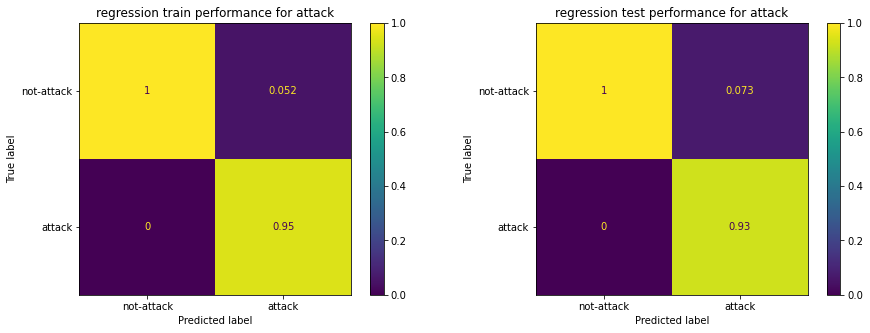

In [139]:
# Solution 

# Training performance:
train_y_pred = modelClosed.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = 'pred')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = modelClosed.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = 'pred')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### 7) Yay! Closed form regression works 

We once again encounter overfitting in our regression problem. To overcome this, we resort to regularization!

Ridge regression is a form of regularization that possess an analytical solution which is as follows:

$\beta = (X^{T} X + \lambda I)^{-1} X^{T} y$

where $\lambda$ is a parameter we need to determine using cross validation once more!

Let's implement a function to perform ridge regression below:

#### Implement a ridge regression class below where you can feed in a single regularization parameter $\lambda$:

In [153]:
# Enter code here


class LinearRegRidgeClosedSolution(object):
    def __int__(self):
        self.betas = []
          
    def fit(self, X, y, regLamba):
        X = self._concatenate_ones(X)
        self.betas = # Enter equation for beta here
    
    def predict(self, X):
        # Enter equation for finding solution here
        return prediction
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

In [140]:
# Solution

class LinearRegRidgeClosedSolution(object):
    def __int__(self):
        self.betas = []
          
    def fit(self, X, y, regLamba):
        X = self._concatenate_ones(X)
        self.betas = np.linalg.inv(X.transpose().dot(X) + regLamba*np.identity(X.shape[1])).dot(X.transpose()).dot(y) 
    
    def predict(self, X):
        b0 = self.betas[0]
        b = self.betas[1:]
        prediction = b0
        prediction += (np.dot(X,b))  
        return prediction
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

### 7 b) Testing our regression function!

Now that we've implemented linear regression with regularization, let's test it out! 

#### Split the data into train and test folds and use the class created above to implement linear regression


In [ ]:
# Enter code here

In [141]:
# Solution

X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

modelridge = LinearRegRidgeClosedSolution()
modelridge.fit(X_train, y_train,10)


#### Now predict the test data using our closed form function and generate a confusion matrix

In [ ]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

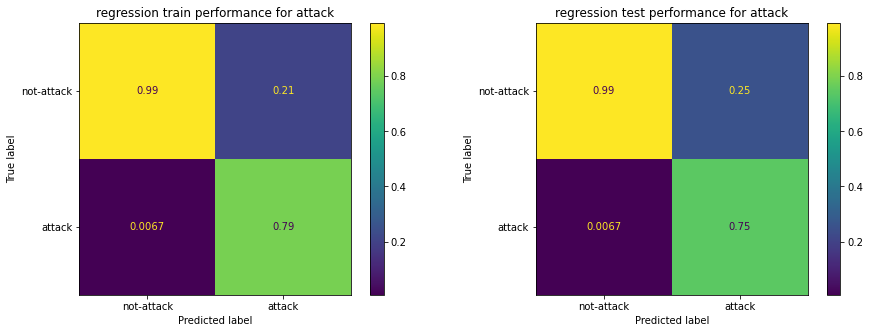

In [142]:
# Solution 

# Training performance:
train_y_pred = modelridge.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = modelridge.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### YAY! Our regularization worked!

### 8) Partial least squares regression (PLS)!

PLS acts as both a dimensionality reduction method and a classification tool. It decomposes neural data into a given number of factors and then uses those factors for classifying a particular variable such as a behavior. 

sklearn once comes to the rescue with a built in implementation in the form of [PLSRegression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html).

PLSRegression is applied as any other regression technique. You can reuse your code above to generate train, test splits and perform cross validation using [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to CV your model. After classification, use the model.x_scores_ to access the latent representations that are most prediction of the behavior here!



C:\Users\Adi\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:85: RuntimeWarning: invalid value encountered in true_divide
  y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score)
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:353: UserWarning: X scores are null at iteration 0
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:85: RuntimeWarning: invalid value encountered in true_divide
  y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score)
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:353: UserWarning: X scores are null at iteration 0
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Adi\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:85: RuntimeWarning: invalid value encountered in true_divide
  y_weights = np.dot(Y.T, x_score) / np.dot(x_score.T, x_score)
C:\Users\Adi\anaconda3\l

Text(0, 0.5, 'MSE')

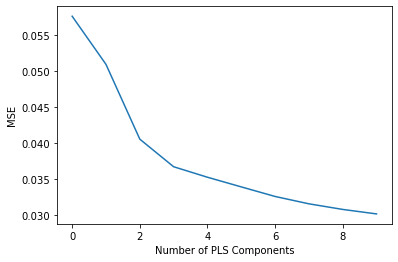

In [170]:
#define cross-validation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale 

X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

# Calculate MSE with only the intercept
score = -1*cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y_train, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 10):
    pls = PLSRegression(n_components=i)
    score = -1*cross_val_score(pls, X_train, y_train, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')

Text(0.5, 1.0, 'regression test performance for attack')

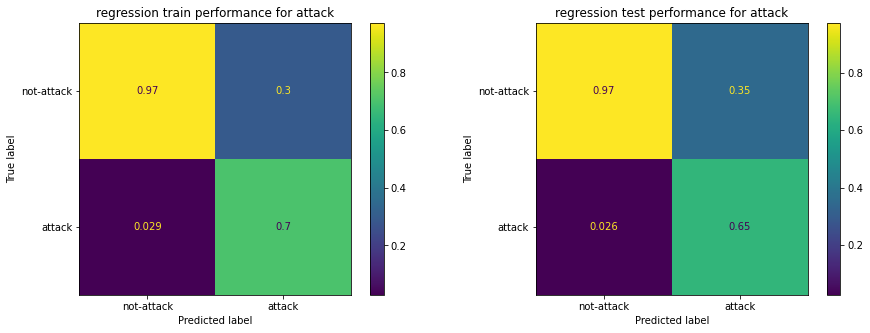

In [171]:
# Solution 

pls = PLSRegression(n_components=3)
pls.fit(X_train, y_train)

# Training performance:
train_y_pred = pls.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = pls.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### As the final part of this notebook, run PLS on the entire dataset and plot the 1st PLS component along with a behavior raster and neural data


In [ ]:
# Enter code here

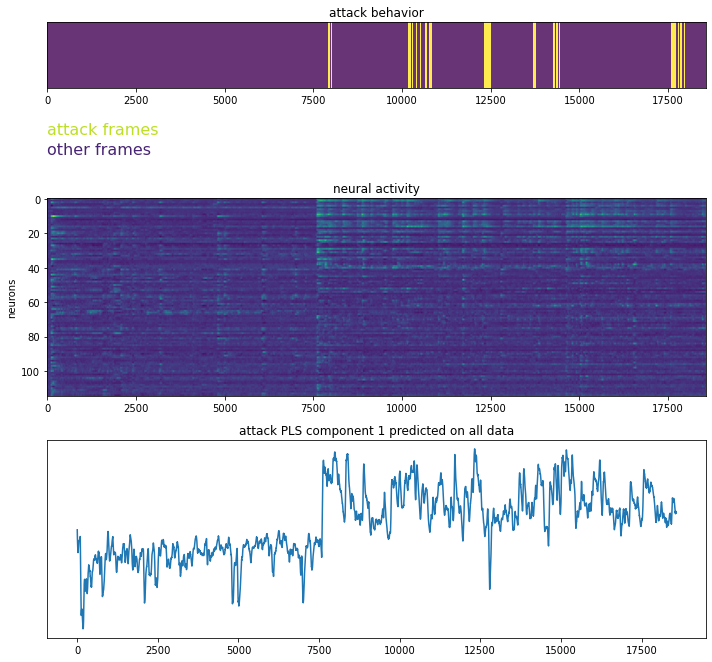

In [173]:
# Solution: 

pls = PLSRegression(n_components=3)
pls.fit(neural_data.T, attack_vector[0])

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.plot(pls.x_scores_[:,0])
ax3.set_yticks([])
ax3.set_title('attack PLS component 1 predicted on all data')

plt.tight_layout() 